In [2]:
# Imports required to support scraping
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Data source for the scrape is the wiki url
WIKI_URL="https://en.wikipedia.org/wiki/List_of_municipalities_in_Georgia_(U.S._state)"

# Pull data from the source url in xml format
req = requests.get(WIKI_URL)
soup = BeautifulSoup(req.content, 'lxml')

# Scrape the table data from the Wiki source required for this project
tables = soup.find("table", class_="wikitable sortable")

# Create an empty dataframe with a column to hold towm/ciry names
col_names =  ['Name']
df  = pd.DataFrame(columns = col_names)


# Parse the sortable table data from source, search for tr and td tags, and load the table data into the pandas dataframe
for tr in tables.find_all('tr'):
   tds = tr.find_all('td')
   if not tds:
      continue
   Name = [td.text.strip()+', GA' for td in tds[:1]]
   if "Total, GA" in Name:
      continue
   df.loc[len(df)] = Name

df.shape

(539, 1)

In [3]:
import re
for index, row in df.iterrows():
   row['Name'] = re.sub("[\(\[].*?[\)\]]", "", row['Name'])

df.head()

,Name
0,"Abbeville, GA"
1,"Acworth, GA"
2,"Adairsville, GA"
3,"Adel, GA"
4,"Adrian, GA"


In [118]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ga_explorer")
df['latitude']=""
df['longitude']=""

for index, row in df.iterrows():
   address = row['Name']
   location = geolocator.geocode(address)
   row['latitude'] = location.latitude
   row['longitude'] = location.longitude

df.shape

KeyboardInterrupt: 

In [ ]:
df

In [16]:
df.to_csv('gacities_ll.csv',index=False)

In [45]:
df1 = pd.read_csv('gacities_ll.csv')
df1.shape

(539, 3)

In [46]:
df1.head()

,Name,latitude,longitude
0,"Abbeville, GA",31.992122,-83.306824
1,"Acworth, GA",34.065933,-84.676880
2,"Adairsville, GA",34.368702,-84.934109
3,"Adel, GA",31.137136,-83.423494
4,"Adrian, GA",32.530722,-82.589299


In [47]:
df = df1
del(df1)

In [122]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [21]:
# create map of Georgia using latitude and longitude values
map_georgia = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# add markers to map
for lat, lng, Name in zip(df['latitude'], df['longitude'], df['Name']):
    label = '{}'.format(Name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_georgia)  
    
map_georgia

In [123]:
# Defining foursquare creds
CLIENT_ID = 'OEJRBJVR5SCXSX0WXRIPUEW12DIMQJNNULLN5BOQNST5TI14'
CLIENT_SECRET = 'ZET1WYWX5F1CWGODLMIHWBFFRB5I1EVFYURKJHWNYAF2XEKQ'
VERSION = '20190421' # Foursquare API version

In [126]:
# Use foursquare and get top N velues for each toronto borough neighborhood
# Setting radius of 100,  and limiting no of venues to 50
LIMIT = 100 # limit of number of venues returned by Foursquare API
rad = 5000 # define radius
section = 'Food'

def getNearbyVenues(names, latitudes, longitudes, radius=rad):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [127]:
ga_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

KeyError: 'groups'

In [25]:
print(ga_venues.shape)
ga_venues.head()

(13118, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abbeville, GA",31.992122,-83.306824,Ophelias,31.992405,-83.306903,Diner
1,"Abbeville, GA",31.992122,-83.306824,Country Kitchen,31.992640,-83.307734,Food
2,"Abbeville, GA",31.992122,-83.306824,Mr B-b-q,31.993763,-83.295976,Food
3,"Acworth, GA",34.065933,-84.676880,Henry's Louisiana Grill,34.066011,-84.677728,Cajun / Creole Restaurant
4,"Acworth, GA",34.065933,-84.676880,Fusco's via Roma,34.065781,-84.677163,Italian Restaurant


In [27]:
ga_venues.to_csv('gavenues.csv',index=False)

In [30]:
import pandas as pd
ga1 = pd.read_csv('gavenues.csv')
ga1.shape

(13118, 7)

In [31]:
ga1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abbeville, GA",31.992122,-83.306824,Ophelias,31.992405,-83.306903,Diner
1,"Abbeville, GA",31.992122,-83.306824,Country Kitchen,31.992640,-83.307734,Food
2,"Abbeville, GA",31.992122,-83.306824,Mr B-b-q,31.993763,-83.295976,Food
3,"Acworth, GA",34.065933,-84.676880,Henry's Louisiana Grill,34.066011,-84.677728,Cajun / Creole Restaurant
4,"Acworth, GA",34.065933,-84.676880,Fusco's via Roma,34.065781,-84.677163,Italian Restaurant


In [32]:
ga_venues = ga1
ga_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Abbeville, GA",3,3,3,3,3,3
"Acworth, GA",100,100,100,100,100,100
"Adairsville, GA",22,22,22,22,22,22
"Adel, GA",23,23,23,23,23,23
"Adrian, GA",1,1,1,1,1,1
"Ailey, GA",4,4,4,4,4,4
"Alamo, GA",2,2,2,2,2,2
"Alapaha, GA",1,1,1,1,1,1
"Albany, GA",70,70,70,70,70,70


In [33]:
print('There are {} uniques categories.'.format(len(ga_venues['Venue Category'].unique())))

There are 102 uniques categories.


In [34]:
print('There are {} uniques Neighborhoods.'.format(len(ga_venues['Neighborhood'].unique())))

There are 471 uniques Neighborhoods.


In [35]:
# one hot encoding
ga_onehot = pd.get_dummies(ga_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ga_onehot['Neighborhood'] = ga_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ga_onehot.columns[-1]] + list(ga_onehot.columns[:-1])
ga_onehot = ga_onehot[fixed_columns]

ga_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Abbeville, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Abbeville, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Acworth, GA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
ga_onehot.shape

(13118, 103)

NameError: name 'plot' is not defined

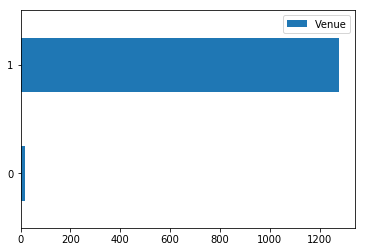

In [29]:
mygp = ga_venues.groupby('Venue Category').count().reset_index()
mygp.sort_values('Venue', ascending=False).head(10)
mygp1 = pd.DataFrame(['Venue Category','Venue'])
mygp1['Venue Category'] = mygp['Venue Category']
mygp1['Venue'] = mygp['Venue']
mygp1.plot(kind='barh')
plot.show()

In [37]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
ga_grouped = ga_onehot.groupby('Neighborhood').mean().reset_index()
ga_grouped

,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
1,"Acworth, GA",0.00,0.130000,0.00,0.00,0.000000,0.00,0.050000,0.01,0.030000,...,0.000000,0.010000,0.01,0.0,0.0,0.0,0.00,0.0,0.000000,0.010000
2,"Adairsville, GA",0.00,0.136364,0.00,0.00,0.090909,0.00,0.045455,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.045455
3,"Adel, GA",0.00,0.130435,0.00,0.00,0.000000,0.00,0.043478,0.00,0.000000,...,0.000000,0.043478,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
4,"Adrian, GA",0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,1.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
5,"Ailey, GA",0.00,0.250000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
6,"Alamo, GA",0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
7,"Alapaha, GA",0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000
8,"Albany, GA",0.00,0.114286,0.00,0.00,0.000000,0.00,0.042857,0.00,0.014286,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.028571
9,"Aldora, GA",0.05,0.100000,0.00,0.00,0.000000,0.00,0.100000,0.00,0.000000,...,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000


In [38]:
print(ga_grouped.shape)
ga_grouped.head()

(471, 103)


,Neighborhood,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Abbeville, GA",0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,"Acworth, GA",0.0,0.130000,0.0,0.0,0.000000,0.0,0.050000,0.01,0.03,...,0.0,0.010000,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
2,"Adairsville, GA",0.0,0.136364,0.0,0.0,0.090909,0.0,0.045455,0.00,0.00,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.045455
3,"Adel, GA",0.0,0.130435,0.0,0.0,0.000000,0.0,0.043478,0.00,0.00,...,0.0,0.043478,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"Adrian, GA",0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,1.00,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [39]:
# print each neighborhood along with the top 1 most common venues
num_top_venues = 1

for hood in ga_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ga_grouped[ga_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbeville, GA----
  venue  freq
0  Food  0.67


----Acworth, GA----
                  venue  freq
0  Fast Food Restaurant  0.14


----Adairsville, GA----
                  venue  freq
0  Fast Food Restaurant  0.23


----Adel, GA----
                  venue  freq
0  Fast Food Restaurant  0.22


----Adrian, GA----
    venue  freq
0  Bakery   1.0


----Ailey, GA----
                venue  freq
0  Chinese Restaurant   0.5


----Alamo, GA----
          venue  freq
0  Burger Joint   0.5


----Alapaha, GA----
  venue  freq
0  Food   1.0


----Albany, GA----
                  venue  freq
0  Fast Food Restaurant  0.23


----Aldora, GA----
         venue  freq
0  Pizza Place  0.15


----Allenhurst, GA----
                  venue  freq
0  Fast Food Restaurant   0.2


----Allentown, GA----
                  venue  freq
0  Fast Food Restaurant   0.5


----Alma, GA----
         venue  freq
0  Pizza Place  0.18


----Alpharetta, GA----
                 venue  freq
0  American Restaurant  0.08


-

KeyboardInterrupt: 

In [40]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
import numpy as np
# display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ga_grouped['Neighborhood']

for ind in np.arange(ga_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ga_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Food,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,"Acworth, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Breakfast Spot
2,"Adairsville, GA",Fast Food Restaurant,American Restaurant,Asian Restaurant,Burger Joint,Mexican Restaurant,Wings Joint,Japanese Restaurant,Sandwich Place,Donut Shop,Breakfast Spot
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Steakhouse,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Tex-Mex Restaurant
4,"Adrian, GA",Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [43]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

ga_grouped_clustering = ga_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ga_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 5, 5, 5, 8, 1, 3, 4, 5, 5], dtype=int32)

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ga_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ga_merged = ga_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

ga_merged.head() # check the last columns!

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,4.0,Food,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,5.0,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Breakfast Spot
2,"Adairsville, GA",34.368702,-84.934109,5.0,Fast Food Restaurant,American Restaurant,Asian Restaurant,Burger Joint,Mexican Restaurant,Wings Joint,Japanese Restaurant,Sandwich Place,Donut Shop,Breakfast Spot
3,"Adel, GA",31.137136,-83.423494,5.0,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Steakhouse,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Tex-Mex Restaurant
4,"Adrian, GA",32.530722,-82.589299,8.0,Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [50]:
ga_merged['Cluster Labels'] = ga_merged['Cluster Labels'].apply(lambda x: int(x) if x == x else 0)
ga_merged.head()

,Name,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",31.992122,-83.306824,4,Food,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,"Acworth, GA",34.065933,-84.676880,5,Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Breakfast Spot
2,"Adairsville, GA",34.368702,-84.934109,5,Fast Food Restaurant,American Restaurant,Asian Restaurant,Burger Joint,Mexican Restaurant,Wings Joint,Japanese Restaurant,Sandwich Place,Donut Shop,Breakfast Spot
3,"Adel, GA",31.137136,-83.423494,5,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Steakhouse,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Tex-Mex Restaurant
4,"Adrian, GA",32.530722,-82.589299,8,Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [52]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [53]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[32.1656, -82.9001], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ga_merged['latitude'], ga_merged['longitude'], ga_merged['Name'], ga_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [54]:
# Cluster 1
ga_merged.loc[ga_merged['Cluster Labels'] == 0, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"Ambrose, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,"Argyle, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,"Avera, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,"Barwick, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,"Bellville, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,"Bostwick, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,"Braswell, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,"Brinson, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,"Brooks, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,"Byromville, GA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Cluster 2
ga_merged.loc[ga_merged['Cluster Labels'] == 1, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Ailey, GA",Chinese Restaurant,American Restaurant,Sandwich Place,Wings Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
13,"Alpharetta, GA",American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Italian Restaurant,New American Restaurant,Café,Burger Joint,Thai Restaurant
21,"Arcade, GA",Seafood Restaurant,Restaurant,Wings Joint,Filipino Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
24,"Arnoldsville, GA",Diner,Mexican Restaurant,Southern / Soul Food Restaurant,Breakfast Spot,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
25,"Ashburn, GA",American Restaurant,BBQ Joint,Food,Mexican Restaurant,Seafood Restaurant,Pizza Place,Deli / Bodega,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place
26,"Athens, GA",Mexican Restaurant,American Restaurant,Pizza Place,New American Restaurant,BBQ Joint,Restaurant,Sandwich Place,Breakfast Spot,Bagel Shop,Burrito Place
27,"Atlanta, GA",American Restaurant,Mexican Restaurant,Restaurant,Pizza Place,Seafood Restaurant,Breakfast Spot,Café,Caribbean Restaurant,Southern / Soul Food Restaurant,New American Restaurant
34,"Avondale Estates, GA",Pizza Place,American Restaurant,Breakfast Spot,Restaurant,Sandwich Place,Gastropub,Indian Restaurant,Fast Food Restaurant,BBQ Joint,Burger Joint
35,"Baconton, GA",New American Restaurant,Breakfast Spot,Wings Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
38,"Ball Ground, GA",Donut Shop,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [56]:
# Cluster 3
ga_merged.loc[ga_merged['Cluster Labels'] == 2, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,"Bluffton, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
70,"Broxton, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
170,"Edison, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
208,"Good Hope, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
227,"Harrison, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
249,"Iron City, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
268,"Kite, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
308,"Marshallville, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
314,"Menlo, GA",American Restaurant,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
382,"Plains, GA",American Restaurant,Food,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [57]:
# Cluster 4
ga_merged.loc[ga_merged['Cluster Labels'] == 3, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Alamo, GA",Café,Burger Joint,Wings Joint,Diner,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
57,"Boston, GA",Pizza Place,Café,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
84,"Canon, GA",Café,Diner,Spanish Restaurant,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
150,"Dexter, GA",Café,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
182,"Fargo, GA",American Restaurant,Café,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
204,"Gillsville, GA",Sandwich Place,Café,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
243,"Homer, GA",Café,Portuguese Restaurant,Burger Joint,Fast Food Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
383,"Plainville, GA",Sandwich Place,Cajun / Creole Restaurant,Café,Wings Joint,Filipino Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
433,"Shady Dale, GA",Restaurant,Café,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
440,"Smithville, GA",Café,Wings Joint,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [58]:
# Cluster 5
ga_merged.loc[ga_merged['Cluster Labels'] == 4, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbeville, GA",Food,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
7,"Alapaha, GA",Food,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
11,"Allentown, GA",Food,Fast Food Restaurant,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
14,"Alston, GA",Food,BBQ Joint,Fast Food Restaurant,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
19,"Arabi, GA",Food,Australian Restaurant,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
23,"Arlington, GA",Food,Mexican Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
47,"Between, GA",Food,Diner,Japanese Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
111,"Cohutta, GA",Food,Southern / Soul Food Restaurant,American Restaurant,BBQ Joint,Food Truck,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
121,"Coolidge, GA",Food,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
149,"De Soto, GA",Food,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [59]:
# Cluster 6
ga_merged.loc[ga_merged['Cluster Labels'] == 5, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Acworth, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,BBQ Joint,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Breakfast Spot
2,"Adairsville, GA",Fast Food Restaurant,American Restaurant,Asian Restaurant,Burger Joint,Mexican Restaurant,Wings Joint,Japanese Restaurant,Sandwich Place,Donut Shop,Breakfast Spot
3,"Adel, GA",Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Steakhouse,Seafood Restaurant,Fried Chicken Joint,Sandwich Place,BBQ Joint,Tex-Mex Restaurant
8,"Albany, GA",Fast Food Restaurant,American Restaurant,Fried Chicken Joint,Seafood Restaurant,Food,Chinese Restaurant,Sandwich Place,BBQ Joint,Wings Joint,Italian Restaurant
9,"Aldora, GA",Pizza Place,Food,Fast Food Restaurant,American Restaurant,BBQ Joint,African Restaurant,Sandwich Place,Southern / Soul Food Restaurant,Steakhouse,Breakfast Spot
10,"Allenhurst, GA",Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Steakhouse,Korean Restaurant,Donut Shop,Seafood Restaurant,Breakfast Spot,Food,Pizza Place
12,"Alma, GA",Fast Food Restaurant,Pizza Place,Wings Joint,BBQ Joint,Sandwich Place,Food,Fried Chicken Joint,Buffet,Diner,Falafel Restaurant
17,"Americus, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Hot Dog Joint,Mexican Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Chinese Restaurant,Food Court,Food
20,"Aragon, GA",Fast Food Restaurant,American Restaurant,Pizza Place,Mexican Restaurant,Breakfast Spot,Japanese Restaurant,Sandwich Place,Southern / Soul Food Restaurant,Wings Joint,Fried Chicken Joint
29,"Auburn, GA",Chinese Restaurant,Sandwich Place,BBQ Joint,Tex-Mex Restaurant,Fast Food Restaurant,Breakfast Spot,Food,Wings Joint,Fish & Chips Shop,Dumpling Restaurant


In [60]:
# Cluster 7
ga_merged.loc[ga_merged['Cluster Labels'] == 6, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Attapulgus, GA",Restaurant,Wings Joint,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
309,"Martin, GA",Restaurant,Wings Joint,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
437,"Shiloh, GA",Restaurant,Wings Joint,Deli / Bodega,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant


In [61]:
# Cluster 8
ga_merged.loc[ga_merged['Cluster Labels'] == 7, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Andersonville, GA",Burger Joint,American Restaurant,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
61,"Bowman, GA",American Restaurant,Food,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
81,"Calhoun, GA",Food,American Restaurant,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
88,"Carnesville, GA",Food,American Restaurant,Mexican Restaurant,Donut Shop,Sandwich Place,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
129,"Cusseta, GA",American Restaurant,Food,BBQ Joint,Sandwich Place,Southern / Soul Food Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
165,"Eastman, GA",American Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,BBQ Joint,Chinese Restaurant,Sandwich Place,Seafood Restaurant,Food,Donut Shop
194,"Franklin, GA",American Restaurant,Food,Mexican Restaurant,Donut Shop,Sandwich Place,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
200,"Gay, GA",American Restaurant,Pizza Place,Wings Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
215,"Greenville, GA",Food,American Restaurant,Café,Diner,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
234,"Hiawassee, GA",American Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Café,Asian Restaurant,BBQ Joint,Breakfast Spot,Mexican Restaurant,Dumpling Restaurant


In [62]:
# Cluster 9
ga_merged.loc[ga_merged['Cluster Labels'] == 8, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Adrian, GA",Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
45,"Berlin, GA",Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
66,"Bronwood, GA",Bakery,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [63]:
# Cluster 10
ga_merged.loc[ga_merged['Cluster Labels'] == 9, ga_merged.columns[[0] + list(range(4, ga_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Alto, GA",BBQ Joint,Diner,Sandwich Place,Spanish Restaurant,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
46,"Bethlehem, GA",BBQ Joint,Bakery,Breakfast Spot,Wings Joint,Food Court,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
48,"Bishop, GA",American Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
60,"Bowersville, GA",Food,BBQ Joint,Wings Joint,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
74,"Buena Vista, GA",BBQ Joint,Pizza Place,Mexican Restaurant,Sandwich Place,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
91,"Cave Spring, GA",Mexican Restaurant,American Restaurant,BBQ Joint,Diner,Steakhouse,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
112,"Colbert, GA",Hot Dog Joint,Seafood Restaurant,BBQ Joint,Bakery,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
114,"Collins, GA",American Restaurant,BBQ Joint,Steakhouse,Wings Joint,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant
144,"Dearing, GA",Food,Restaurant,BBQ Joint,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
186,"Flovilla, GA",Mexican Restaurant,American Restaurant,BBQ Joint,Wings Joint,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
